# 5. 해결과제2
## DEA 효율성 분석 및 보호구역내 시설물 설치


### **[목차]**

**1. DEA 분석 : 효율성 파악**   
    - 데이터불러오기  
    - 상관분석  
    - DEA  
     
**2. DEA 결과분석**  
    - 효율집단, 비효율집단 분류  
    - 시설물 설치 지역 1차 필터링  
      
**3. 시설물 설치 보호구역 선정**  
      - 위험점수 계산
    
**4. 보호구역 내 시설물 종류 선정**   
    - 후보 시설물 모색
    - 입지선정 
 ** **

In [1]:
library(tidyverse)
library(data.table)
library(Benchmarking)
library(leaflet)
library(rgdal)
library(sf)
library(tidyverse,warn.conflicts = FALSE, quietly = TRUE, verbose = FALSE )

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: lpSolveAPI

Loading required package: ucminf

Loading required package: quadprog

Loading required package: sp

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.2, released 2020/07/07
Path to GDAL shared files: /usr/local/gdal-3.1.2/share/gdal
GDAL binary built with GEOS: FALSE 
Loaded PROJ runtime: Re

## 1. DEA 분석 : 효율성 파악
### 1) 데이터 불러오기

In [2]:
data = fread('어린이보호구역_시설물_데이터(면적고려).csv',header = TRUE,
               stringsAsFactors = FALSE,
               data.table = FALSE,
               encoding = "UTF-8")

In [3]:
data %>% str()

'data.frame':	89 obs. of  12 variables:
 $ 시설종류    : chr  "특수학교" "초등학교" "초등학교" "초등학교" ...
 $ 시설명      : chr  "성심학교" "광성초등학교" "대호초등학교" "매홀초등학교" ...
 $ geometry    : chr  "POLYGON ((127.0186474601138 37.17676162814226, 127.0186420161261 37.17667331011843, 127.0186257800303 37.176585"| __truncated__ "POLYGON ((127.0408348702595 37.18419651722915, 127.0408293999012 37.18410820034981, 127.0408131366282 37.184020"| __truncated__ "POLYGON ((127.0590142976562 37.15910574475602, 127.0590088079869 37.15901742835677, 127.0589925291772 37.158929"| __truncated__ "POLYGON ((127.064407751564 37.16274839347206, 127.0644022553509 37.16266007738316, 127.0643859695413 37.1625726"| __truncated__ ...
 $ accident_cnt: num  0 0.00566 0.0011 0.00132 0 ...
 $ sign_cnt    : num  0 0.005659 0 0.000265 0 ...
 $ CW_cnt      : num  0 0 0.00138 0.00132 0 ...
 $ highCW_cnt  : num  0 0 0.000825 0 0 ...
 $ bump_cnt    : num  0 0 0.000963 0.000795 0 ...
 $ TL_cnt      : num  0 0 0.00055 0 0 ...
 $ CCTV_cnt    : num  0 0

### 2) 상관분석

Warning message in melt(., na.rm = T):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”


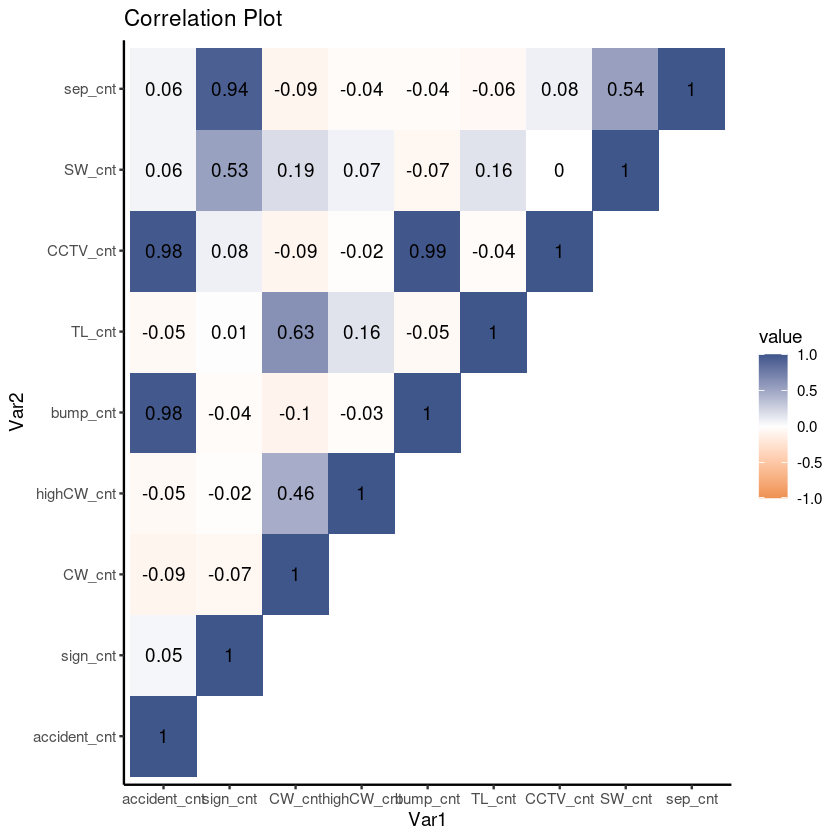

In [4]:
cor = cor(data[,4:12])  %>% round(2)

cor[lower.tri(cor)]=NA
cor %>% melt(na.rm=T)%>% 
    ggplot(aes(x=Var1, y=Var2, fill=value))+
    geom_tile()+
    scale_fill_gradient2(low="#ED9253",high="#3F568B", midpoint = 0, limit = c(-1,1))+
    ggtitle("Correlation Plot")+
    geom_text(aes(label = value))+
    theme_classic()

**산출변수(사고건수)와 투입변수 간 상관관계:**  
양: 도로안전표지(매우 약), 과속방지턱(강), CCTV(강), 인도(매우 약), 도로분리대(매우 약)  
음: 횡단보도(매우 약), 고원식횡단보도(매우 약), 신호등(매우 약)  
  
  
**투입변수 간 상관관계:**  
양 & 강: 도로분리대 & 도로안전표지, CCTV & 과속방지턱   
양 & 살짝강: 도로분리대 & 인도, 인도 & 도로안전표지, 신호등 & 횡단보도, 고원식 횡단보도 & 횡단보도  
음: 모두 매우 약한 상관관계

#### 일반적으로 DEA의 투입과 산출변수 사이의 상관관계는 투입변수가 증가하면 산출변수도 증가하는 양(+)의 상관을 가져야 합니다.(Mostafa, 2009).   (참고문헌: <DEA(자료포락분석)를 이용한 도시철도 전동차 운영효율 연구>)  
음의 상관이 나온 변수는 dea를 실시하기 어려우므로, correlation plot 중 음수가 나온 변수는 유의도까지 다시 확인해보았습니다.

In [5]:
# 산출변수(accident_cnt)와 음의 상관이었던 투입변수들 CW_cnt, highCW_cnt, TL_cnt
cor.test(data[,6], data[,4], method='pearson')
cor.test(data[,7], data[,4], method='pearson')
cor.test(data[,9], data[,4], method='pearson')


	Pearson's product-moment correlation

data:  data[, 6] and data[, 4]
t = -0.82752, df = 87, p-value = 0.4102
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2912681  0.1221326
sample estimates:
       cor 
-0.0883719 



	Pearson's product-moment correlation

data:  data[, 7] and data[, 4]
t = -0.4521, df = 87, p-value = 0.6523
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2541078  0.1614716
sample estimates:
       cor 
-0.0484131 



	Pearson's product-moment correlation

data:  data[, 9] and data[, 4]
t = -0.49508, df = 87, p-value = 0.6218
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2584082  0.1569857
sample estimates:
        cor 
-0.05300393 


셋 모두 유의수준 a = 0.05에서 **유의하지 않은 것**으로 나타나 그대로 분석을 진행한다.

### 3) DEA

#### ㄱ. 산출변수 matrix만들기
DEA는 산출량을 극대화하는 maximization을 목적으로 하므로 그 목적함수가 최솟값이 되어야 합니다.  
현 과제에서의 산출량 극대화란 사고 건수의 최소화를 뜻하므로 산출변수(accident_cnt)의 역수를 사용했습니다.

In [6]:
Y = data.frame(inv = rep(0,89))
Y$inv = 1/data$accident_cnt

# 사고 건수가 0건이었던 경우는 그 역수는 0으로 처리
Y$inv[which(Y$inv==Inf)]=0

Y = Y  %>% as.matrix()

In [7]:
Y %>% head()

inv
0.0000
176.7223
908.7710
755.0619
0.0000
542.9723


#### ㄴ. 투입요소 matrix만들기

In [8]:
X = data[,c(5:12)]  %>% as.matrix()

In [9]:
X %>% head()

sign_cnt,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,CCTV_cnt,SW_cnt,sep_cnt
0.0000000000,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.000000000
0.0056585946,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0028292973,0.0056585946,0.002829297
0.0000000000,0.001375484,0.0008252904,0.0009628388,0.0005501936,0.0004126452,0.0004126452,0.000000000
0.0002648789,0.001324395,0.0000000000,0.0007946368,0.0000000000,0.0000000000,0.0013243947,0.000000000
0.0000000000,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0006602545,0.0000000000,0.000000000
0.0000000000,0.000000000,0.0000000000,0.0009208573,0.0000000000,0.0002302143,0.0000000000,0.000000000


#### ㄷ. DEA 실시하기

In [10]:
# BCC 모형: RTS = 'vrs' 옵션을 추가했습니다
dea = dea(X, Y, RTS = 'vrs')
dea

 [1] 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0854080
 [8] 0.2777557 0.0000000 0.0070387 0.1741884 0.0090957 0.0000000 0.0000000
[15] 0.0000000 0.0829507 0.0000000 1.0000000 0.0129428 0.0000000 0.0000000
[22] 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.1080801 0.0000000
[29] 0.8704142 0.0007769 0.0055170 0.0000000 0.4154055 0.0000000 0.0000000
[36] 0.0445478 1.0000000 0.0000000 0.0000000 0.5411982 0.0000000 1.0000000
[43] 0.0000000 0.0000000 0.0000000 0.0000000 0.2076225 1.0000000 0.0000000
[50] 0.0000000 0.5240189 0.0000000 0.2019304 0.6089042 0.4056930 0.2210013
[57] 0.0066225 1.0000000 1.0000000 0.5661900 0.8010345 0.0000000 0.2252451
[64] 0.0818983 0.0027921 0.5392240 0.0350162 0.4618980 0.0000000 1.0000000
[71] 1.0000000 0.0000000 0.5123451 1.0000000 0.0712613 0.1495619 0.0000000
[78] 0.0000000 1.0000000 0.0000000 0.0000000 0.0000000 1.0000000 0.0000000
[85] 1.0000000 0.0000000 0.0191060 0.3674973 0.0000000

In [11]:
# DEA 결과는 다음과 같이 나왔습니다.
dea_df = data.frame(시설명 = data$시설명, 효율성점수 = dea$eff)
head(dea_df)

,시설명,효율성점수
,<fct>,<dbl>
1,성심학교,0
2,광성초등학교,0
3,대호초등학교,0
4,매홀초등학교,0
5,삼미초등학교,0
6,성산초등학교,0


## 2. DEA 결과분석
효율성 점수를 근거로 효율집단과 비효율집단으로 분류했습니다.  
이때 효율집단은 효율성점수가 1인 집단을 | 비효율집단은 효율성점수가 1이 아닌 집단을 의미합니다.  

### 1) 효율집단, 비효율집단 분류
#### ㄱ. 집단 분류

In [12]:
eff = filter(dea_df, 효율성점수 == 1)
ineff = filter(dea_df, 효율성점수 != 1)

In [13]:
# 효율집단 확인
eff

시설명,효율성점수
<fct>,<dbl>
금암초등학교,1
펀키즈 유치원,1
해에게서소년에게어린이집,1
로뎀장애아전담 어린이집,1
영락어린이집,1
시립예일어린이집,1
아이사랑어린이집,1
중앙어린이집,1
늘해랑어린이집,1


효율집단은 총 12개였습니다.

In [14]:
# 비효율집단 확인
ineff = ineff[order(-ineff$효율성점수),] #효율성점수를 기준으로 내림차순 정렬하여 저장했습니다.
head(ineff)

,시설명,효율성점수
,<fct>,<dbl>
28,오산유치원,0.8704142
55,좋은아이어린이집,0.8010345
50,시립비둘기어린이집,0.6089042
54,베이비캐슬어린이집,0.5661900
38,오르다유치원,0.5411982
60,경희어린이집,0.5392240


비효율집단은 총 77개로, '효율성'을 기준으로 한 교통안전시설물 우선 설치 구역의 1차적 고려 대상이 됩니다.

#### ㄴ. 비효율 집단, 효율성점수 결과


In [15]:
ineff %>% filter(효율성점수==0) %>% nrow()

[1] 43

**효율성점수가 0인 비효율지역 : 43개**  
**효율성점수가 0이 아닌 비효율지역 : 34개** 
  
DEA는 outlier에 취약하여 효율성점수가 0으로 나오는 경우가 발생하게 되는데,   
절대적인 시설물 개수의 값이 이상치처럼 보일 수 있어 '도로 면적 대비 시설물 개수'의 값을 사용하였지만   
여전히 데이터의 특성상 DEA 결과에 영향을 미친 것으로 보입니다.  
  
본 연구에서는 현재 지정된 어린이 보호구역을 최대한 많이 고려하고자하여 이상치로 여겨지는 행을 제거하지 않았습니다.     
따라서 효율성점수가 0.6 이상인 집단을 적당한 효율성을 지닌 집단으로 간주하여 고려 대상에서 배제하는 것을 제외하고,  
이것 이상으로 효율성점수를 활용하지 않았습니다.

#### ㄷ. 효율집단, 비효율집단 시각화

In [16]:
# 데이터 정리
dea_data= data[,c(2,4:12)]
dea_data$dea_result = dea$eff
dea_data  %>% head()

,시설명,accident_cnt,sign_cnt,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,CCTV_cnt,SW_cnt,sep_cnt,dea_result
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,성심학교,0.000000000,0.0000000000,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.000000000,0
2,광성초등학교,0.005658595,0.0056585946,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0028292973,0.0056585946,0.002829297,0
3,대호초등학교,0.001100387,0.0000000000,0.001375484,0.0008252904,0.0009628388,0.0005501936,0.0004126452,0.0004126452,0.000000000,0
4,매홀초등학교,0.001324395,0.0002648789,0.001324395,0.0000000000,0.0007946368,0.0000000000,0.0000000000,0.0013243947,0.000000000,0
5,삼미초등학교,0.000000000,0.0000000000,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0006602545,0.0000000000,0.000000000,0
6,성산초등학교,0.001841715,0.0000000000,0.000000000,0.0000000000,0.0009208573,0.0000000000,0.0002302143,0.0000000000,0.000000000,0


In [17]:
# circle모양의 시각화를 위해 시설(어린이 보호구역) 중심좌표를 이용하기로 하여 자료를 불러옵니다.
data9 = read_csv("9.오산시_어린이보호구역.csv")
dea_data = left_join(dea_data, data9[,c(2,6,7)],by="시설명")
dea_data  %>% head()

Parsed with column specification:
cols(
  시설종류 = col_character(),
  시설명 = col_character(),
  CCTV설치여부 = col_character(),
  CCTV설치대수 = col_double(),
  보호구역도로폭 = col_double(),
  보호구역_경도 = col_double(),
  보호구역_위도 = col_double()
)



,시설명,accident_cnt,sign_cnt,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,CCTV_cnt,SW_cnt,sep_cnt,dea_result,보호구역_경도,보호구역_위도
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,성심학교,0.000000000,0.0000000000,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.000000000,0,127.0175,37.17676
2,광성초등학교,0.005658595,0.0056585946,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0028292973,0.0056585946,0.002829297,0,127.0397,37.18420
3,대호초등학교,0.001100387,0.0000000000,0.001375484,0.0008252904,0.0009628388,0.0005501936,0.0004126452,0.0004126452,0.000000000,0,127.0579,37.15911
4,매홀초등학교,0.001324395,0.0002648789,0.001324395,0.0000000000,0.0007946368,0.0000000000,0.0000000000,0.0013243947,0.000000000,0,127.0633,37.16275
5,삼미초등학교,0.000000000,0.0000000000,0.000000000,0.0000000000,0.0000000000,0.0000000000,0.0006602545,0.0000000000,0.000000000,0,127.0603,37.19136
6,성산초등학교,0.001841715,0.0000000000,0.000000000,0.0000000000,0.0009208573,0.0000000000,0.0002302143,0.0000000000,0.000000000,0,127.0670,37.15044


In [18]:
# 좌표 변수명 변경
dea_data = dea_data %>% rename(lng=보호구역_경도,lat=보호구역_위도)

In [19]:
# 효율집단 저장
dea_eff = dea_data[dea_data$dea_result == 1,] #효율성점수가 1인 데이터
# 비효율집단(분석대상) 저장
dea_target = dea_data[dea_data$dea_result != 1,] #효율성 점수가 1이 아닌 데이터

In [20]:
data31 = st_read("31.오산시_법정경계(시군구).geojson") #지도시각화시 사용할 오산시 경계

Reading layer `31' from data source `/opt/app-root/src/31.오산시_법정경계(시군구).geojson' using driver `GeoJSON'
Simple feature collection with 1 feature and 2 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 126.9949 ymin: 37.12532 xmax: 127.1031 ymax: 37.20087
geographic CRS: WGS 84


In [21]:
# 효율집단 12개소 지도 시각화
leaflet() %>% addTiles() %>% 
    setView(lng = 127.048396, lat = 37.165397, zoom = 12) %>% 
    addProviderTiles("CartoDB.Positron") %>% 
    addPolygons(data=data31,color="#475974") %>%  #오산시경계
    addCircleMarkers(data = dea_eff, color ="#0C90AD",radius=3) #효율집단

Assuming "lng" and "lat" are longitude and latitude, respectively



HTML widgets cannot be represented in plain text (need html)

In [22]:
# 비효율집단 77개소 시각화
pal=colorNumeric(  c("#8C615A","#D46751","#F7A290","#FBCDC0","#F1EAE0"),  domain = 0:1)
leaflet() %>% addTiles() %>% 
    setView(lng = 127.048396, lat = 37.165397, zoom = 12) %>% 
    addProviderTiles("CartoDB.Positron") %>% 
    addPolygons(data=data31,color="#475974") %>%  #오산시경계
    addCircleMarkers(data = dplyr::filter(dea_target,(dea_result>=0)&(dea_result<0.2)), color = "#8C615A",radius=3) %>%  
    addCircleMarkers(data = dplyr::filter(dea_target,(dea_result>=0.2)&(dea_result<0.4)), color = "#D46751",radius=3) %>%  
    addCircleMarkers(data = dplyr::filter(dea_target,(dea_result>=0.4)&(dea_result<0.6)), color = "#F7A290",radius=3)  %>% 
    addCircleMarkers(data = dplyr::filter(dea_target,(dea_result>=0.6)&(dea_result<0.8)), color = "#FBCDC0",radius=3)  %>% 
    addCircleMarkers(data = dplyr::filter(dea_target,(dea_result>=0.8)&(dea_result<1.0)), color = "#F1EAE0",radius=3)  %>% 
    addLegend(position = 'topright', pal = pal, value = 0:1, opacity = 1)

Assuming "lng" and "lat" are longitude and latitude, respectively

Assuming "lng" and "lat" are longitude and latitude, respectively

Assuming "lng" and "lat" are longitude and latitude, respectively

Assuming "lng" and "lat" are longitude and latitude, respectively

Assuming "lng" and "lat" are longitude and latitude, respectively



HTML widgets cannot be represented in plain text (need html)

### 2) 효율성점수에 따라 1차적 필터링  
효율성점수가 0.6 미만인 것만을 시설물 우선 설치 구역 고려 대상으로 선정하였습니다.

In [23]:
ineff_fltrd = ineff[ineff$효율성점수 < 0.6,]
rownames(ineff_fltrd) = 1:74
head(ineff_fltrd)

,시설명,효율성점수
,<fct>,<dbl>
1,베이비캐슬어린이집,0.5661900
2,오르다유치원,0.5411982
3,경희어린이집,0.5392240
4,청원어린이집,0.5240189
5,해오름어린이집,0.5123451
6,대일어린이집,0.4618980


### 추가) DEA결과 의의
효율집단(12개소)과 고려 대상(74개소)의 도로면적 대비 시설물 개수 / 어린이 교통사고 건수를 비교해보았습니다.

In [24]:
# 효율집단의 시설물별 평균 개수 확인
eff_facil = filter(data, 시설명 %in% eff$시설명)
eff_facil = apply(eff_facil[,5:12], 2, mean)  %>% as.data.frame()

In [25]:
# 고려 대상의 시설물별 평균 개수 확인
ineff_facil = filter(data, 시설명 %in% ineff_fltrd$시설명)
ineff_facil = apply(ineff_facil[,5:12], 2, mean)  %>% as.data.frame()

In [26]:
# 전체 시설물별 개수 총합 계산
sum_facil = apply(data[-c(28,55,50),5:12], 2, sum)  %>% as.data.frame()

In [27]:
# 전체 시설물별 개수 평균 계산
mean_facil = apply(data[-c(28,55,50),5:12], 2, mean)  %>% as.data.frame()

In [28]:
facilcount = cbind(eff_facil, ineff_facil, sum_facil, mean_facil)
colnames(facilcount) = c('효율집단', '고려대상', '총합', '총평균')

In [29]:
facilcount$차 = facilcount$고려대상 - facilcount$효율집단
facilcount$총합대비차 = facilcount$차 / facilcount$총합
facilcount$평균대비차 = facilcount$차 / facilcount$총평균
facilcount

,효율집단,고려대상,총합,총평균,차,총합대비차,평균대비차
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sign_cnt,4.797675e-05,1.719425e-04,0.013365905,1.554175e-04,1.239658e-04,0.009274777,0.7976308
CW_cnt,1.985627e-04,4.533678e-04,0.035959306,4.181315e-04,2.548051e-04,0.007085929,0.6093899
highCW_cnt,2.651617e-05,7.867802e-05,0.006140368,7.139962e-05,5.216185e-05,0.008494906,0.7305619
bump_cnt,4.336636e-04,1.163237e-03,0.091861189,1.068153e-03,7.295732e-04,0.007942126,0.6830229
TL_cnt,4.141782e-05,3.071031e-04,0.022587644,2.626470e-04,2.656853e-04,0.011762417,1.0115679
CCTV_cnt,1.493074e-04,6.393030e-04,0.049220090,5.723266e-04,4.899956e-04,0.009955196,0.8561469
SW_cnt,3.762797e-04,6.344916e-04,0.051077931,5.939294e-04,2.582118e-04,0.005055252,0.4347517
sep_cnt,1.538899e-05,7.546111e-05,0.005703723,6.632236e-05,6.007212e-05,0.010532090,0.9057598


In [30]:
# 효율집단과 고려 대상의 사고 건수 차이 계산
accident = data.frame(mean(filter(data, 시설명 %in% filter(eff)$시설명)$accident_cnt), 
                      mean(filter(data, 시설명 %in% filter(ineff)$시설명)$accident_cnt))

colnames(accident) = c('효율집단', '고려대상')
rownames(accident) = 'accident_cnt'

In [31]:
accident$총합 = sum(data[-c(28,55,50),4])
accident$총평균 = mean(data[-c(28,55,50),4])
accident$차 = accident$고려대상 - accident$효율집단
accident$총합대비차 = accident$차 / accident$총합
accident$평균대비차 = accident$차 / accident$총평균

In [32]:
result = rbind(facilcount, accident)
result

,효율집단,고려대상,총합,총평균,차,총합대비차,평균대비차
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sign_cnt,4.797675e-05,1.719425e-04,0.013365905,1.554175e-04,1.239658e-04,0.009274777,0.7976308
CW_cnt,1.985627e-04,4.533678e-04,0.035959306,4.181315e-04,2.548051e-04,0.007085929,0.6093899
highCW_cnt,2.651617e-05,7.867802e-05,0.006140368,7.139962e-05,5.216185e-05,0.008494906,0.7305619
bump_cnt,4.336636e-04,1.163237e-03,0.091861189,1.068153e-03,7.295732e-04,0.007942126,0.6830229
TL_cnt,4.141782e-05,3.071031e-04,0.022587644,2.626470e-04,2.656853e-04,0.011762417,1.0115679
CCTV_cnt,1.493074e-04,6.393030e-04,0.049220090,5.723266e-04,4.899956e-04,0.009955196,0.8561469
SW_cnt,3.762797e-04,6.344916e-04,0.051077931,5.939294e-04,2.582118e-04,0.005055252,0.4347517
sep_cnt,1.538899e-05,7.546111e-05,0.005703723,6.632236e-05,6.007212e-05,0.010532090,0.9057598
accident_cnt,3.275520e-04,1.465530e-03,0.112187571,1.304507e-03,1.137978e-03,0.010143526,0.8723432


#### 변수명(column)의 의미
- '효율집단' : 효율집단의 시설물 개수 / 교통사고 건수 평균  
- '고려대상' : 고려 대상의 시설물 개수 / 교통사고 건수 평균  
- '총합' : 효율집단과 고려 대상의 시설물 개수 / 교통사고 건수 총합  
- '평균' : 효율집단과 고려 대상의 시설물 개수 / 교통사고 건수 평균  
- '차' : 효율집단과 고려대상 간 시설물 개수 / 교통사고 건수 차이  
- '총합대비차' : '차'를 '총합'으로 나누어 시설물의 종류와 상관 없이 상대적 비교가 가능하도록 만든 변수
- '평균대비차' : '차'를 '평균'으로 나누어 시설물의 종류와 상관 없이 상대적 비교가 가능하도록 만든 변수

효율집단(12개소)과 고려 대상(74개소)의 도로면적당 어린이 교통사고 건수 차가 작은 값으로 도출되었습니다.  
이를 통해 고려 대상의 시설물 설치수준이 효율집단 수준으로 작아지더라도 비슷한 사고수준이 유지될 것으로 판단할 수 있습니다.  
(참고문헌: <DEA를 활용한 어린이보호구역개선사업의 효율성 평가에 관한 연구>)

In [33]:
# 총합대비차(평균대비차)가 큰 순서 (시설물)
arrange(result[1:8,], desc(abs(result[1:8,]$총합대비차)))

,효율집단,고려대상,총합,총평균,차,총합대비차,평균대비차
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TL_cnt,4.141782e-05,3.071031e-04,0.022587644,2.626470e-04,2.656853e-04,0.011762417,1.0115679
sep_cnt,1.538899e-05,7.546111e-05,0.005703723,6.632236e-05,6.007212e-05,0.010532090,0.9057598
CCTV_cnt,1.493074e-04,6.393030e-04,0.049220090,5.723266e-04,4.899956e-04,0.009955196,0.8561469
sign_cnt,4.797675e-05,1.719425e-04,0.013365905,1.554175e-04,1.239658e-04,0.009274777,0.7976308
highCW_cnt,2.651617e-05,7.867802e-05,0.006140368,7.139962e-05,5.216185e-05,0.008494906,0.7305619
bump_cnt,4.336636e-04,1.163237e-03,0.091861189,1.068153e-03,7.295732e-04,0.007942126,0.6830229
CW_cnt,1.985627e-04,4.533678e-04,0.035959306,4.181315e-04,2.548051e-04,0.007085929,0.6093899
SW_cnt,3.762797e-04,6.344916e-04,0.051077931,5.939294e-04,2.582118e-04,0.005055252,0.4347517


**효율집단 > 고려 대상: X**  
**효율집단 = 고려 대상: X**  
**효율집단 < 고려 대상: 신호등 - 도로분리대 - CCTV - 도로안전표지 - 고원식횡단보도 - 과속방지턱 - 횡단보도 - 인도 (내림차순)**  
  
  
설치개수가 많으면 효율성이 높아질 것으로 기대되는 변수는 없었습니다.  
따라서 고려 대상에 추가적으로 안전시설물을 설치함에 있어 모든 종류의 시설물에 대해 필히 유의해야 합니다.  
주어진 과제가 안전시설물의 '추가적 설치'라 본 과제에서는 설치할 시설물만을 선정하겠지만,  
이 결과를 토대로 **안전시설물 제거의 대책**을 세워보는 것도 의미가 있을 것으로 예상됩니다.


## 4. 시설물 설치 보호구역 선정
### 1) 위험점수 계산
**(PSI) X (어린이 교통사고 건수) / (도로 면적)**

In [34]:
s_zone_evl = st_read('어린이보호구역_시설물_데이터(면적포함).geojson') 
rg_result=st_read('result1_data.geojson') #해결과제1의 psi결과(격자)

Reading layer `어린이보호구역_시설물_데이터(면적포함)' from data source `/opt/app-root/src/어린이보호구역_시설물_데이터(면적포함).geojson' using driver `GeoJSON'
Simple feature collection with 89 features and 12 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: 127.0164 ymin: 37.12642 xmax: 127.092 ymax: 37.19878
geographic CRS: WGS 84
Reading layer `result1_data' from data source `/opt/app-root/src/result1_data.geojson' using driver `GeoJSON'
Simple feature collection with 2887 features and 7 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 126.9953 ymin: 37.1249 xmax: 127.098 ymax: 37.2005
geographic CRS: WGS 84


In [35]:
# 효율성점수 0.6 미만으로 고려 대상 범위 한정
s_zone_evl=filter(s_zone_evl,시설명 %in% ineff_fltrd$시설명)
head(s_zone_evl)

,시설종류,시설명,accident_cnt,sign_cnt,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,CCTV_cnt,SW_cnt,sep_cnt,road_area,geometry
,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<POLYGON [°]>
1,특수학교,성심학교,0,0,0,0,0,0,0,0,0,325.2076,POLYGON ((127.0186 37.17676...
2,초등학교,광성초등학교,2,2,0,0,0,0,1,2,1,353.4447,"POLYGON ((127.0408 37.1842,..."
3,초등학교,대호초등학교,8,0,10,6,7,4,3,3,0,7270.1681,"POLYGON ((127.059 37.15911,..."
4,초등학교,매홀초등학교,5,1,5,0,3,0,0,5,0,3775.3095,POLYGON ((127.0644 37.16275...
5,초등학교,삼미초등학교,0,0,0,0,0,0,1,0,0,1514.5674,POLYGON ((127.0614 37.19136...
6,초등학교,성산초등학교,8,0,0,0,4,0,1,0,0,4343.7784,POLYGON ((127.0682 37.15044...


In [36]:
# 어린이보호구역별로 겹치는 격자들의 PSI 평균 계산
PSI = NULL
for (i in 1:nrow(s_zone_evl)){
    p = mean(st_intersection(s_zone_evl[i,],rg_result)$PSI)
    PSI=c(PSI,p)
}

although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
although coordinates are longitude/latitude, st_intersection assumes that they are planar

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
although coordinates are longitude/

In [37]:
PSI

[1]  0.0009614303  0.0987698136  0.4935169579  0.2648648863 -0.0047706253
 [6]  0.4799351745  0.1386393408  0.0913664117  0.1665892127  0.1650258881
[11] -0.2294312815  0.0495098377  0.9382548096 -0.3275447024  0.3862081695
[16] -0.2350208355 -0.4821948312  0.1677738451 -0.0986419599 -0.2545425339
[21]  0.5038718844 -0.2553070274 -0.1131988569 -0.3288057426  0.6140710476
[26] -0.3354974134  0.7530184514  0.0267644686  0.1039673197 -0.1387373770
[31]  0.2409536880 -0.0858975357 -0.0552309095  0.0212385494 -0.0470011654
[36] -0.0343167393 -0.2494628612 -0.2054454466 -0.0041023644 -0.0827267770
[41] -0.2561507119 -0.1964554297 -0.0680086589 -0.1350594323  0.1586413560
[46]  0.0678048493 -0.2647702668  0.0258195914  0.0852074787 -0.3086241831
[51]  0.1742147798 -0.2750162011 -0.0857352865  0.0537965379  0.1633045732
[56]  0.0181942072  0.0018272405  0.0239951189 -0.0575928057  0.0101042701
[61] -0.0915651366 -0.2009500438  0.2151846241  0.3058528852 -0.5402432221
[66] -0.4732021439 -0.5380343332 -0.0316432821 -0.0853859028  0.1375254262
[71] -0.1227923834  0.4200451350  0.0544717559  0.0612422386

In [38]:
# s_zone_evl의 column으로 PSI값 추가
s_zone_evl$PSI = PSI

head(s_zone_evl)

,시설종류,시설명,accident_cnt,sign_cnt,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,CCTV_cnt,SW_cnt,sep_cnt,road_area,geometry,PSI
,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<POLYGON [°]>,<dbl>
1,특수학교,성심학교,0,0,0,0,0,0,0,0,0,325.2076,POLYGON ((127.0186 37.17676...,0.0009614303
2,초등학교,광성초등학교,2,2,0,0,0,0,1,2,1,353.4447,"POLYGON ((127.0408 37.1842,...",0.0987698136
3,초등학교,대호초등학교,8,0,10,6,7,4,3,3,0,7270.1681,"POLYGON ((127.059 37.15911,...",0.4935169579
4,초등학교,매홀초등학교,5,1,5,0,3,0,0,5,0,3775.3095,POLYGON ((127.0644 37.16275...,0.2648648863
5,초등학교,삼미초등학교,0,0,0,0,0,0,1,0,0,1514.5674,POLYGON ((127.0614 37.19136...,-0.0047706253
6,초등학교,성산초등학교,8,0,0,0,4,0,1,0,0,4343.7784,POLYGON ((127.0682 37.15044...,0.4799351745


In [39]:
#위험지수 계산
s_zone_evl$danger2_score = s_zone_evl$PSI * s_zone_evl$accident_cnt / s_zone_evl$road_area
s_zone_evl = s_zone_evl %>% arrange(-danger2_score) #위험점수기준 내림차순 정렬으로 저장했습니다.

In [40]:
# 입지 우선지역인 상위 25개소
s_zone_rank25 = head(s_zone_evl,25)
s_zone_rank25

,시설종류,시설명,accident_cnt,sign_cnt,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,CCTV_cnt,SW_cnt,sep_cnt,road_area,PSI,danger2_score,geometry
,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<POLYGON [°]>
1,초등학교,오산초등학교,5,0,0,0,4,0,2,0,0,84.93499,0.16658921,9.806866e-03,POLYGON ((127.0513 37.14516...
2,초등학교,세미초등학교,2,0,0,0,0,0,0,2,0,303.41424,0.50387188,3.321346e-03,POLYGON ((127.0655 37.17448...
3,유치원,대일유치원,9,0,2,0,3,0,0,0,0,2337.64810,0.61407105,2.364188e-03,POLYGON ((127.0717 37.13355...
4,유치원,예인유치원,13,0,2,0,0,3,0,2,0,4724.40307,0.75301845,2.072059e-03,POLYGON ((127.0793 37.15363...
5,초등학교,운산초등학교,11,4,6,2,0,7,3,3,0,6083.59464,0.93825481,1.696497e-03,POLYGON ((127.0787 37.15264...
6,초등학교,운천초등학교,8,0,3,0,2,3,1,4,0,2469.72484,0.38620817,1.251016e-03,POLYGON ((127.0809 37.15595...
7,초등학교,성산초등학교,8,0,0,0,4,0,1,0,0,4343.77843,0.47993517,8.839036e-04,POLYGON ((127.0682 37.15044...
8,초등학교,광성초등학교,2,2,0,0,0,0,1,2,1,353.44465,0.09876981,5.588983e-04,"POLYGON ((127.0408 37.1842,..."
9,초등학교,대호초등학교,8,0,10,6,7,4,3,3,0,7270.16807,0.49351696,5.430598e-04,"POLYGON ((127.059 37.15911,..."


In [41]:
# 상위 25개소 지도 시각화
pal <- colorFactor("Purples", s_zone_rank25$danger2_score)

leaflet() %>% addTiles() %>% 
    setView(lng = 127.048396, lat = 37.165397, zoom = 12) %>% 
    addProviderTiles("CartoDB.Positron") %>% 
    addPolygons(data = data31, color = "#475974") %>% 
    addPolygons(data = s_zone_rank25, color = ~pal(danger2_score), popup = ~시설명) %>% 
    addLegend(position = 'topright', pal = pal, value = s_zone_rank25$danger2_score, opacity = 1)

Warning message in RColorBrewer::brewer.pal(max(3, n), palette):
“n too large, allowed maximum for palette Purples is 9
Returning the palette you asked for with that many colors
”
Warning message in RColorBrewer::brewer.pal(max(3, n), palette):
“n too large, allowed maximum for palette Purples is 9
Returning the palette you asked for with that many colors
”
Warning message in RColorBrewer::brewer.pal(max(3, n), palette):
“n too large, allowed maximum for palette Purples is 9
Returning the palette you asked for with that many colors
”


HTML widgets cannot be represented in plain text (need html)

## 4. 보호구역 내 시설물 종류 선정
### 1) 후보 시설물 모색

In [42]:
# 데이터프레임 정리
rank25 = as.data.frame(s_zone_rank25[,2:11])

# 시설물 종류 확인
rank25 %>% colnames()

[1] "시설명"       "accident_cnt" "sign_cnt"     "CW_cnt"       "highCW_cnt"  
 [6] "bump_cnt"     "TL_cnt"       "CCTV_cnt"     "SW_cnt"       "sep_cnt"     
[11] "geometry"

각각 도로안전표지, 횡단보도, 고원식횡단보도, 과속방지턱, 신호등, 단속카메라, 인도, 중앙분리대 를 의미합니다.

#### 시설물이 전무한 것을 우선적으로 살펴보고자, 결정을 돕는 데이터프레임을 만듭니다.

In [43]:
cndi = as.data.frame(matrix(nrow=25,ncol=9))
colnames(cndi) = c("시설명","1st","2nd","3rd","4th","5th","6th","7th","8th")
cndi$시설명 = rank25$시설명

for (i in 1:25){
    kinds = NULL
    for (j in 1:8){
        if (rank25[i,j+2] == 0){
            kinds = c(kinds,colnames(rank25)[j+2])}}
    k = length(kinds)+1
    cndi[i,2:k] = kinds}

cndi

시설명,1st,2nd,3rd,4th,5th,6th,7th,8th
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
오산초등학교,sign_cnt,CW_cnt,highCW_cnt,TL_cnt,SW_cnt,sep_cnt,NA,NA
세미초등학교,sign_cnt,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,CCTV_cnt,sep_cnt,NA
대일유치원,sign_cnt,highCW_cnt,TL_cnt,CCTV_cnt,SW_cnt,sep_cnt,NA,NA
예인유치원,sign_cnt,highCW_cnt,bump_cnt,CCTV_cnt,sep_cnt,NA,NA,NA
운산초등학교,bump_cnt,sep_cnt,NA,NA,NA,NA,NA,NA
운천초등학교,sign_cnt,highCW_cnt,sep_cnt,NA,NA,NA,NA,NA
성산초등학교,sign_cnt,CW_cnt,highCW_cnt,TL_cnt,SW_cnt,sep_cnt,NA,NA
광성초등학교,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,NA,NA,NA,NA
대호초등학교,sign_cnt,sep_cnt,NA,NA,NA,NA,NA,NA


#### 분석에 사용한 모든 시설물의 입지에 대해 우선 순위를 정합니다.
개수 기준 오름차순으로 하는 데이터프레임을 만들었습니다.

In [44]:
cndi2 = as.data.frame(matrix(nrow=25, ncol=9))
colnames(cndi2) = c("시설명","1st","2nd","3rd","4th","5th","6th","7th","8th")
cndi2$시설명 = rank25$시설명

for (i in 1:25){
    cndi2[i,2:9]=rank25[i,3:10] %>% sort %>% colnames
}
    
cndi2

시설명,1st,2nd,3rd,4th,5th,6th,7th,8th
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
오산초등학교,sign_cnt,CW_cnt,highCW_cnt,TL_cnt,SW_cnt,sep_cnt,CCTV_cnt,bump_cnt
세미초등학교,sign_cnt,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,CCTV_cnt,sep_cnt,SW_cnt
대일유치원,sign_cnt,highCW_cnt,TL_cnt,CCTV_cnt,SW_cnt,sep_cnt,CW_cnt,bump_cnt
예인유치원,sign_cnt,highCW_cnt,bump_cnt,CCTV_cnt,sep_cnt,CW_cnt,SW_cnt,TL_cnt
운산초등학교,bump_cnt,sep_cnt,highCW_cnt,CCTV_cnt,SW_cnt,sign_cnt,CW_cnt,TL_cnt
운천초등학교,sign_cnt,highCW_cnt,sep_cnt,CCTV_cnt,bump_cnt,CW_cnt,TL_cnt,SW_cnt
성산초등학교,sign_cnt,CW_cnt,highCW_cnt,TL_cnt,SW_cnt,sep_cnt,CCTV_cnt,bump_cnt
광성초등학교,CW_cnt,highCW_cnt,bump_cnt,TL_cnt,CCTV_cnt,sep_cnt,sign_cnt,SW_cnt
대호초등학교,sign_cnt,sep_cnt,CCTV_cnt,SW_cnt,TL_cnt,highCW_cnt,bump_cnt,CW_cnt


#### ㄱ. 시설물 선정 개요
- 'cndi'를 근거로 해당 어린이 보호구역에 없는 시설물을 우선적으로 고려합니다.  
- 'cndi2'를 근거로 'cndi'에 없는 시설물을 순서대로 보완합니다.  

#### ㄴ. 시설물 설명
- 고원식 횡단보도는 해당 보호구역에 수요가 있을 것으로 예상되는 곳(ex. 출입구 근방)에 설치되어 있는지, 횡단보도 간 거리가 과도하게 멀지 않은지, 일반 횡단보도를 고원식으로 바꿀 필요가 있는지 등을 고려하여 결정했습니다. 이때 일반 횡단보도의 고원식 횡단보도로의 변경은 일반 횡단보도 근방의 과속방지턱 여부를 살펴보았습니다. (과속방지턱과 고원식 횡단보도가 차량 감속에 효과적이라는 분석 참고 (출처: <DEA를 활용한 어린이보호구역개선사업의 효율성 평가에 관한 연구>))  
- 과속방지턱은 범위 내 개수가 충분한지, 직선도로인 곳에 차량 속도를 제한하는 시설물이 존재하는지를 기준으로 판단했습니다.
- 분리대는 크게 도로의 중앙분리대와 인도와 차도의 분리대(보행자안전펜스)로 구분했습니다. 중앙분리대는 도로가 꽤 넓지만 주변에 횡단보도가 없어 무단횡단의 가능성이 있는 곳을 중심으로, 보행자안전펜스는 도로가 좁아 중앙분리대를 설치하기에 적절치 않으나 차량의 차로 이탈과 무단횡단 방지 등을 이유로 도로와 인도의 구분이 필요한 곳을 중심으로 살폈습니다.
- 중앙선이 없는 도로임과 동시에 인도 또한 없는 경우는 주정차단속카메라를 설치해 위험으로부터 아이들을 보호하고자 합니다.
- 도로에 중앙선이 없고 보행 분리도 되어있지 않으나 이미 단속카메라가 있는 경우, 단속카메라만으로 사고 예방을 하기에 충분하지 않다고 여겨 인도를 설치합니다.

#### ㄷ. 입지 선택 방법
- 주어진 데이터가 실제 시설물과 도로상황을 완전히 반영하고 있다고 보기 어렵습니다. 
- 어린이 교통사고 데이터가 격자별 사고수로만 존재해, 구체적으로 어느 지점에서 어느정도 규모의 사고가 났는지 알 수 없어 논리적인 코드를 구현하기 어렵습니다.
- 주어진 데이터에 존재하는 시설물 외에 기타 시설물이 필요한 경우 직접 확인 후 설치를 계획했습니다. (복잡한 교차로의 인도에 볼라드 설치 여부, 어린이 보호구역 적색 노면 표시 여부 등)


#### 구체적인 시설물 입지는 네이버지도 로드뷰, 구글맵 스트리트뷰를 참고하였음을 알립니다.

### 2) 입지 선정

In [45]:
# 우선 설치 구역 20개소와 구역별 시설물 종류
place = c('대일유치원','예인유치원', '운산초등학교', '운천초등학교', '광성초등학교', '대호초등학교', '매홀초등학교', '시립은여울어린이집',
          '시립남부어린이집', '시립가온어린이집',  '세교복지타운어린이집', '자람터어린이집','키즈청호어린이집', '동화마을유치원',
          '오산고현초등학교', '문시초등학교', '둥근해어린이집', '성호초등학교', '이화유치원', '오산원일초등학교')

facil = c('노면표시, 주정차단속카메라', '고원식횡단보도', '중앙분리대', '볼라드', '고원식횡단보도', '볼라드, 주정차단속카메라', '과속단속카메라', '보행자안전펜스',
          '과속방지턱', '고원식횡단보도', '고원식횡단보도', '인도',  '노면표시', '주정차단속카메라',
          '고원식횡단보도', '고원식횡단보도', '주정차단속카메라', '보행자안전펜스', '보행자안전펜스', '노면표시')

In [46]:
finalfacil = filter(s_zone_rank25, s_zone_rank25$시설명 %in% place)
finalfacil$facil = facil
colnames(finalfacil)[2] = 'place'
finalfacil = finalfacil[,c(2,15,16)]
finalfacil

,place,geometry,facil
,<fct>,<POLYGON [°]>,<chr>
1,대일유치원,POLYGON ((127.0717 37.13355...,"노면표시, 주정차단속카메라"
2,예인유치원,POLYGON ((127.0793 37.15363...,고원식횡단보도
3,운산초등학교,POLYGON ((127.0787 37.15264...,중앙분리대
4,운천초등학교,POLYGON ((127.0809 37.15595...,볼라드
5,광성초등학교,"POLYGON ((127.0408 37.1842,...",고원식횡단보도
6,대호초등학교,"POLYGON ((127.059 37.15911,...","볼라드, 주정차단속카메라"
7,매홀초등학교,POLYGON ((127.0644 37.16275...,과속단속카메라
8,시립은여울어린이집,"POLYGON ((127.068 37.17095,...",보행자안전펜스
9,시립남부어린이집,POLYGON ((127.0735 37.13856...,과속방지턱


In [47]:
# 최종 결과 지도 시각화
pal=colorFactor("viridis", finalfacil$facil)

leaflet() %>% addTiles() %>% 
    setView(lng = 127.048396, lat = 37.165397, zoom = 12) %>% 
    addProviderTiles("CartoDB.Positron") %>% 
    addPolygons(data = data31, color = "#475974") %>% 
    addPolygons(data = finalfacil, color=~pal(facil), 
                popup = paste("구역명: ", place, "<br>",
                           "시설물 종류: ", facil)) %>% 
    addLegend(position = 'topright', pal = pal, value = finalfacil$facil, opacity = 1)

HTML widgets cannot be represented in plain text (need html)

In [48]:
st_write(finalfacil, "analysis2_result.geojson") ##최종 어린이보호구역 외 어린이교통사고위험지역 20개소 선정

Writing layer `analysis2_result' to data source `analysis2_result.geojson' using driver `GeoJSON'
Writing 20 features with 2 fields and geometry type Polygon.
